In [1]:
import argparse
import os
os.umask(0)
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import ArgoTestDataset
from utils import Logger, load_pretrain

torch.cuda.set_device(1)

from lanegcn import get_model
config, Dataset, collate_fn, net, loss, post_process, opt = get_model()

ckpt_path_g = '/data/fyy/new_prediction/argoverse/generator32.000.ckpt'
ckpt_g = torch.load(ckpt_path_g, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt_g["state_dict"])

net.eval()
net.cuda()

dataset = ArgoTestDataset('val', config, train=False)

data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=True,
)


In [2]:
# preds = {}
# gts = {}
# cities = {}

# erro = 0   # 有60个错误
# flag = 0
# erro_argo_idx = []
# for ii, data in tqdm(enumerate(data_loader)):
#     data = dict(data)
#     with torch.no_grad():
#         rel, output = net(data)
#         results = []
#         for i in range(len(output["reg"])):
#             if len(output["reg"][i]) <= 1:
#                 results.append(output["reg"][i][0].detach().cpu().numpy())
#                 erro += 1
#                 flag = 1
#             else:
#                 results.append(output["reg"][i][1].detach().cpu().numpy())
#     for i, (argo_idx, pred_traj) in enumerate(zip(data["argo_id"], results)):
#         preds[argo_idx] = pred_traj.squeeze()
#         cities[argo_idx] = data["city"][i]
#         gts[argo_idx] = data["gt_preds"][i][0] if "gt_preds" in data else None
#         if flag == 1:
#             erro_argo_idx.append(argo_idx)
#     flag = 0
# # save for further visualizations
# res = dict(
#     preds = preds,
#     gts = gts,
#     cities = cities,
# )

In [3]:
import pickle
file_name = '/data/fyy/new_prediction/argoverse/intersection_data/val_erro_argo_idx.pkl'

# with open(file_name, 'wb') as file:
#     pickle.dump(erro_argo_idx, file)
    
with open(file_name, 'rb') as file:
    erro_argo_idx = pickle.load(file)
print(len(erro_argo_idx))

1856


In [4]:
file_name = '/data/fyy/new_prediction/argoverse/intersection_data/val_pred.pkl'

# with open(file_name, 'wb') as file:
#     pickle.dump(preds, file)
    
with open(file_name, 'rb') as file:
    preds = pickle.load(file)

In [5]:
import matplotlib.pyplot as plt
from vis_utils import ArgoMapVisualizer
from typing import Any, Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Polygon
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
import copy

map_vis = ArgoMapVisualizer()
    
data_path = '/data/fyy/lanegcn/dataset/dataset/val/data'
avl = ArgoverseForecastingLoader(data_path)
avl.seq_list = sorted(avl.seq_list)

In [6]:
def get_data(idx): 
    city_name = copy.deepcopy(avl[idx].city)
    data_seq = copy.deepcopy(avl[idx].seq_df)   # (len, 6)
    timestamp = np.sort(np.unique(data_seq['TIMESTAMP'].values))
    
    mapping = dict()
    for i, ts in enumerate(timestamp):
        mapping[ts] = i
        
    # 某个场景下的所有轨迹，5s内的轨迹，(len, 2)
    trajs = np.concatenate((
            data_seq.X.to_numpy().reshape(-1, 1),
            data_seq.Y.to_numpy().reshape(-1, 1)), 1)

    steps = [mapping[x] for x in data_seq['TIMESTAMP'].values]
    steps = np.asarray(steps, np.int64)

    objs = data_seq.groupby(['TRACK_ID', 'OBJECT_TYPE']).groups
    keys = list(objs.keys())
    obj_type = [x[1] for x in keys]

    av_idx = obj_type.index('AV')  # av_index = 0，获取AV的索引
    idcs = objs[keys[av_idx]]

    av_traj = trajs[idcs]  # av_traj.shape = (50, 2)
    av_step = steps[idcs]  # av_step.shape = (50,)
    
    # 获取周围车辆的轨迹
    del keys[av_idx]
    ctx_trajs, ctx_steps = [], []  
    for key in keys:
        idcs = objs[key]
        ctx_trajs.append(trajs[idcs])
        ctx_steps.append(steps[idcs])
        
    data = dict()
    data['city'] = city_name
    data['trajs'] = [av_traj] + ctx_trajs
    data['steps'] = [av_step] + ctx_steps
    data['argo_id'] = int(avl.seq_list[idx].name[:-4])

    orig = data['trajs'][0][19].copy().astype(np.float32)
    pre = data['trajs'][0][18] - orig
    theta = np.pi - np.arctan2(pre[1], pre[0])

    rot = np.asarray([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]], np.float32)


    feats, ctrs, gt_preds, has_preds, traj1, trajs2 = [], [], [], [], [], []
    for traj, step in zip(data['trajs'], data['steps']):
        if 19 not in step:
            continue
            
        gt_pred = np.zeros((30, 2), np.float32)
        has_pred = np.zeros(30, bool)
        future_mask = np.logical_and(step >= 20, step < 50)
        post_step = step[future_mask] - 20
        post_traj = traj[future_mask]
        gt_pred[post_step] = post_traj
        has_pred[post_step] = 1


        all_traj = traj.copy().astype(np.float32)
        has_traj = np.zeros(50, bool)
        all_mask = np.logical_and(step >= 0, step < 50)
        all_traj = traj[all_mask]
        all_step = step[all_mask]
        # print(all_traj)
        has_traj[all_step] = 1

        obs_mask = step < 20
        step = step[obs_mask]
        traj = traj[obs_mask]
        idcs = step.argsort()
        step = step[idcs]
        traj = traj[idcs]

        for i in range(len(step)):
            if step[i] == 19 - (len(step) - 1) + i:
                break
        step = step[i:]
        traj = traj[i:]


        feat = np.zeros((20, 3), np.float32)
        feat[step, :2] = np.matmul(rot, (traj - orig.reshape(-1, 2)).T).T
        feat[step, 2] = 1.0


        traj2 = np.zeros((50,3), np.float32)
        traj2[all_step, :2] = np.matmul(rot, (all_traj - orig.reshape(-1,2)).T).T
        traj2[all_step, 2] = 1
        

        x_min, x_max, y_min, y_max = config['pred_range']
        if feat[-1, 0] < x_min or feat[-1, 0] > x_max or feat[-1, 1] < y_min or feat[-1, 1] > y_max:
            continue

        ctrs.append(feat[-1, :2].copy())
        traj1.append(feat.copy())

        feat[1:, :2] -= feat[:-1, :2]
        feat[step[0], :2] = 0
        feats.append(feat)
        gt_preds.append(gt_pred)
        has_preds.append(has_pred)
        trajs2.append(traj2)

    feats = np.asarray(feats, np.float32)
    ctrs = np.asarray(ctrs, np.float32)
    gt_preds = np.asarray(gt_preds, np.float32)
    has_preds = np.asarray(has_preds, bool)
    traj1 = np.asarray(traj1, np.float32)
    trajs2 = np.asarray(trajs2, np.float32)

    data['feats'] = feats
    data['traj1'] = traj1
    data['ctrs'] = ctrs
    data['orig'] = orig
    data['theta'] = theta
    data['rot'] = rot
    data['gt_preds'] = gt_preds
    data['has_preds'] = has_preds
    data['trajs2'] = trajs2
    return data

In [7]:
file_name = '/data/fyy/new_prediction/argoverse/intersection_data/intention_val_idx.pkl'
with open(file_name, 'rb') as file:
    intention_data = pickle.load(file)

i = 4
idx = intention_data[i]
data = get_data(idx)
city_name = data['city']
orig = data['orig']
seq_id = data['argo_id']
rot = data['rot']
trajs_obs = data['trajs2'][:, :, :2]
traj_pred = preds[seq_id]


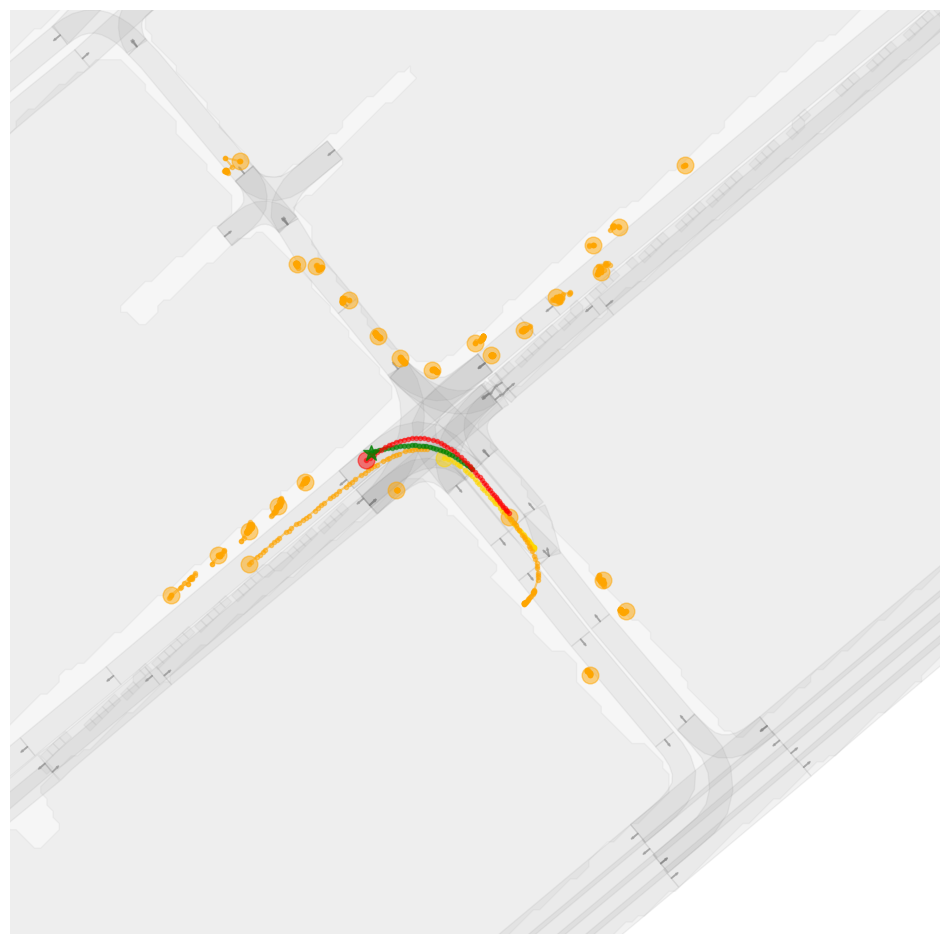

In [8]:
_, ax = plt.subplots(figsize=(12, 12))
ax.axis('equal')
plt.axis('off')
map_vis.show_surrounding_elements(ax, city_name, orig)

for i, traj in enumerate(trajs_obs):
    traj = torch.tensor(traj)
    mask = torch.any(traj != 0, dim=1)
    traj = traj[mask]
    traj = np.matmul(rot.T, traj.T).T + orig
    zorder = 10
    if i == 0:
            clr = 'r'
            zorder = 20
    elif i == 1:
            clr = 'gold'
    else:
            clr = 'orange'
    ax.plot(traj[:, 0], traj[:, 1], marker='.', alpha=0.5, color=clr, zorder=zorder)
    ax.plot(traj[-1, 0], traj[-1, 1], alpha=0.5, color=clr, marker='o', zorder=zorder, markersize=12)

av_traj_pred = traj_pred[0]
ax.plot(av_traj_pred[:, 0], av_traj_pred[:, 1], alpha=0.5, color='g', linewidth=3, marker='.', zorder=15)
ax.plot(av_traj_pred[-1, 0], av_traj_pred[-1, 1], marker='*', color='g', markersize=12, alpha=0.75, zorder=30)
# plt.savefig('my_plotb3_4.png', format='png', dpi=300)

TypeError: any() received an invalid combination of arguments - got (bool, dim=int), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


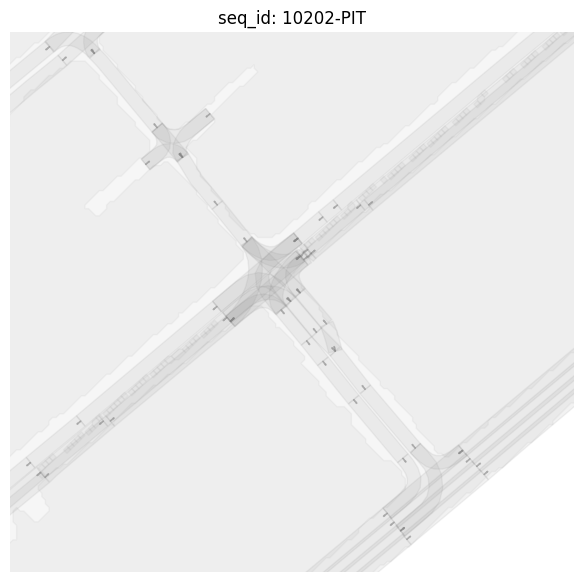

In [ ]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.03, 0.05, 0.94, 0.9])

ax.axis('equal')
plt.axis('off')
ax.set_title('seq_id: {}-{}'.format(seq_id, city_name))

map_vis.show_surrounding_elements(ax, city_name, orig)

trajs_plot = []
traj_lines = []
traj_ends = []

for i, traj in enumerate(trajs_obs):
    traj = torch.tensor(traj)
    traj = np.matmul(rot.T, traj.T).T + orig
    zorder = 10
    if i == 0:
            clr = 'r'
            zorder = 20
    else:
            clr = 'orange'
    trajs_plot.append({'traj':traj, 'color':clr, 'zorder':zorder})
    
    traj_line, = ax.plot([],[], marker='.', alpha=0.5, color=clr, zorder=zorder)
    traj_end, = ax.plot([], [], alpha=0.5, color=clr, marker='o', zorder=zorder, markersize=12)
    traj_lines.append(traj_line)
    traj_ends.append(traj_end)


av_traj_pred = traj_pred[0]
traj_pred_line, = ax.plot([], [], alpha=0.5, color=clr, linewidth=3, marker='.', zorder=15)
traj_pred_end, = ax.plot([], [], alpha=0.75, marker='*', color=clr, markersize=12, zorder=30)

count = 0
def update_plot(*arg):
    global count
    count += 1
    if count > 21:
        traj_pred_line.set_data(traj[:count-21,0],traj[:count-21,1])
        traj_pred_end.set_data(traj[count-21-1,0],traj[count-21-1,1])
    for i, traj_line in enumerate(traj_lines):
        traj = trajs_plot[i]['traj'][:count]
        # mask = torch.any(traj != orig, dim=1)
        # traj = traj[mask]
        if len(traj)!=0:
            traj_line.set_data(traj[:,0], traj[:,1])
            traj_ends[i].set_data(traj[-1,0], traj[-1,1])
    return traj_lines+traj_ends+traj_pred_lines+traj_pred_ends

ani = animation.FuncAnimation(fig, update_plot, interval=500, save_count=49, blit=True, repeat=False)
# ani.save('./gif/animation'+str(ii)+'_'+str(m)+'aaa.gif', writer='imagemagick')